In [1]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random
import copy

import math


from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


import warnings
warnings.filterwarnings("ignore") # In order not to show the warnings in the notebook


# 1. Data Preprocessing

### a. Importing and Analysing the Data

In [2]:
# Importing data 
Bitcoin_data = pd.read_csv('data.csv', parse_dates=['Date'], sep=',', index_col='Date')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
Bitcoin_data.head(5)

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2014-09-16,465.864014,468.174011,452.421997,457.334015,21056800.0,457.334015
2014-09-17,456.859985,456.859985,413.104004,424.440002,34483200.0,424.440002
2014-09-18,424.102997,427.834992,384.532013,394.795990,37919700.0,394.795990
2014-09-19,394.673004,423.295990,389.882996,408.903992,36863600.0,408.903992
2014-09-20,408.084992,412.425995,393.181000,398.821014,26580100.0,398.821014


In [3]:
# checking for nulls
Bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2586 entries, 2014-09-16 to 2021-10-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2586 non-null   float64
 1   High       2586 non-null   float64
 2   Low        2586 non-null   float64
 3   Adj Close  2586 non-null   float64
 4   Volume     2586 non-null   float64
 5   Close      2586 non-null   float64
dtypes: float64(6)
memory usage: 141.4 KB


In [4]:
# checking if close is not equal to adj close
Bitcoin_data[Bitcoin_data['Close']!=Bitcoin_data['Adj Close']]

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,


In [5]:
# checking the main parameters
Bitcoin_data.describe()

,Open,High,Low,Adj Close,Volume,Close
count,2586.000000,2586.000000,2586.000000,2586.000000,2.586000e+03,2586.000000
mean,9460.479761,9729.703537,9173.223236,9483.798763,1.375499e+10,9483.798763
std,13881.464139,14299.916556,13424.115329,13919.027751,1.989196e+10,13919.027751
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,178.102997
25%,577.754990,582.823242,573.438751,577.567490,7.406615e+07,577.567490
50%,5515.076172,5647.827149,5353.012940,5540.485108,4.568140e+09,5540.485108
75%,9699.704834,9908.871582,9507.834717,9700.673340,2.224211e+10,9700.673340
max,63523.753910,64863.097660,62208.964840,63503.457030,3.510000e+11,63503.457030


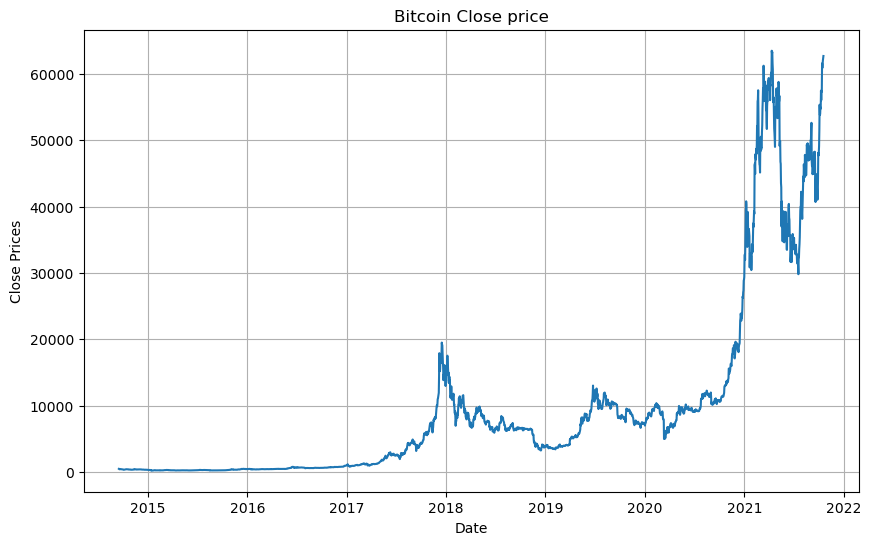

In [6]:
# Plot closing prices
df_close = Bitcoin_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Bitcoin Close price');

In [7]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

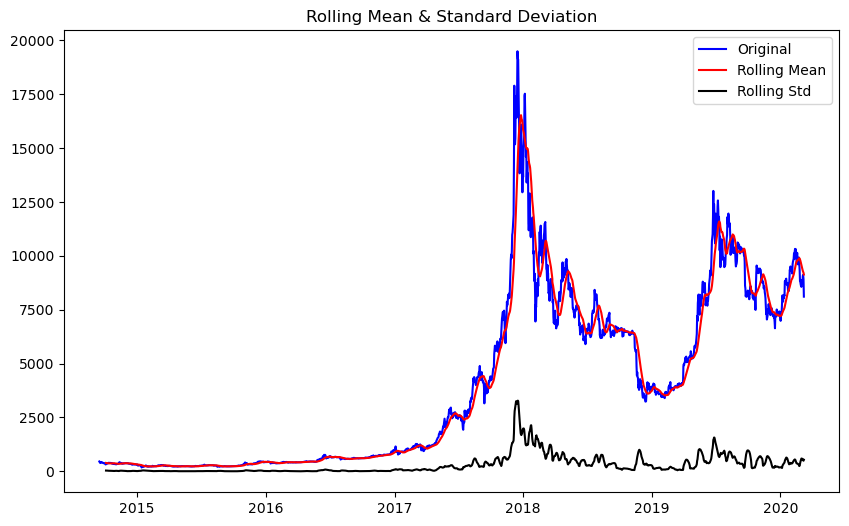

Results of Dickey-Fuller Test:
Test Statistic                   -1.744147
p-value                           0.408522
#Lags Used                       21.000000
Number of Observations Used    1978.000000
Critical Value (1%)              -3.433660
Critical Value (5%)              -2.863002
Critical Value (10%)             -2.567548
dtype: float64


In [8]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

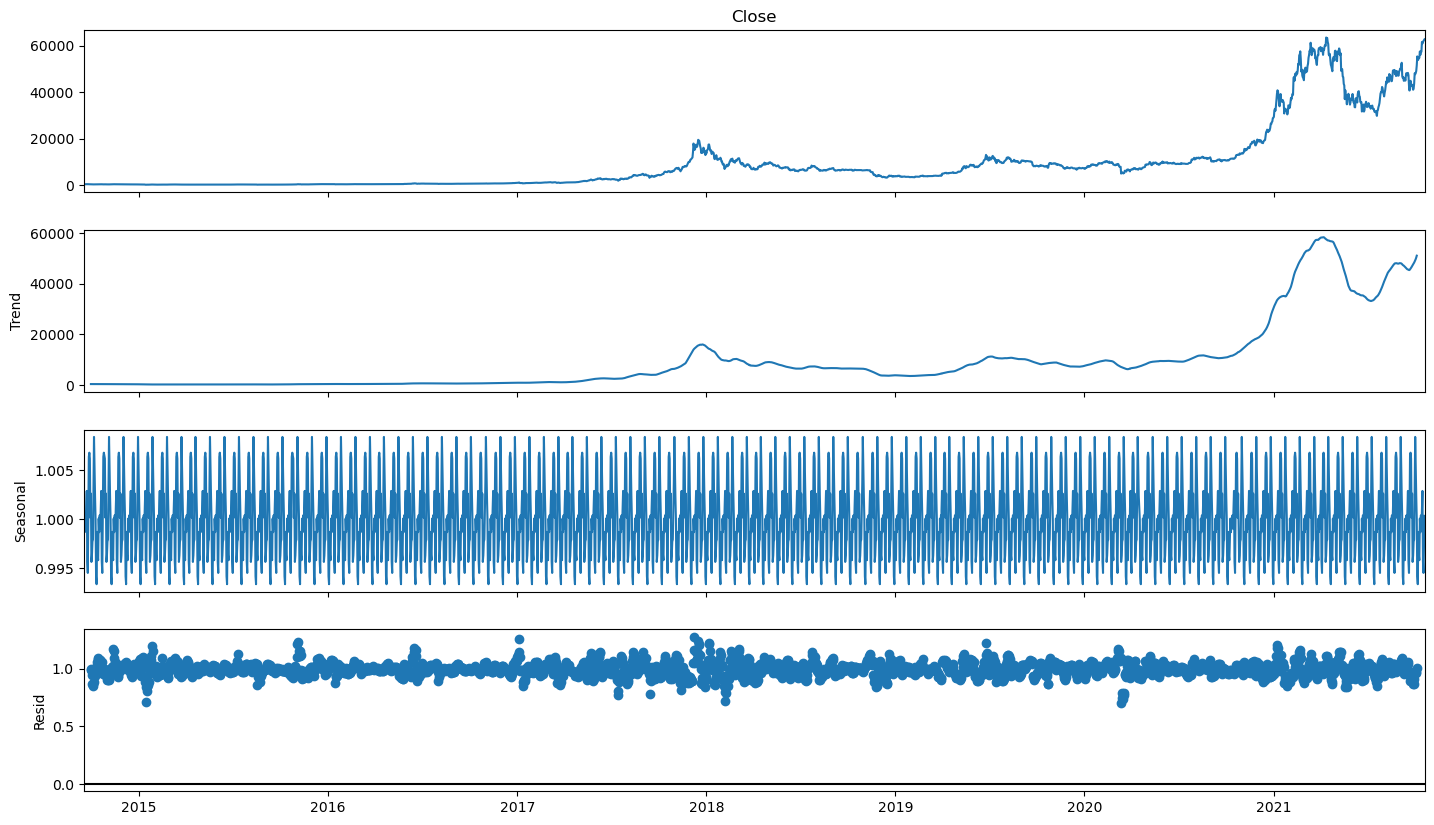

In [9]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a month
# The result below is just to have a first visualization of trend andseasonality. Here we take a monthly average but to forecast a bitcoin 
# price, it is more difficult than that to choose the right number of days to average on
result = seasonal_decompose(df_close, model='multiplicative', period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9);

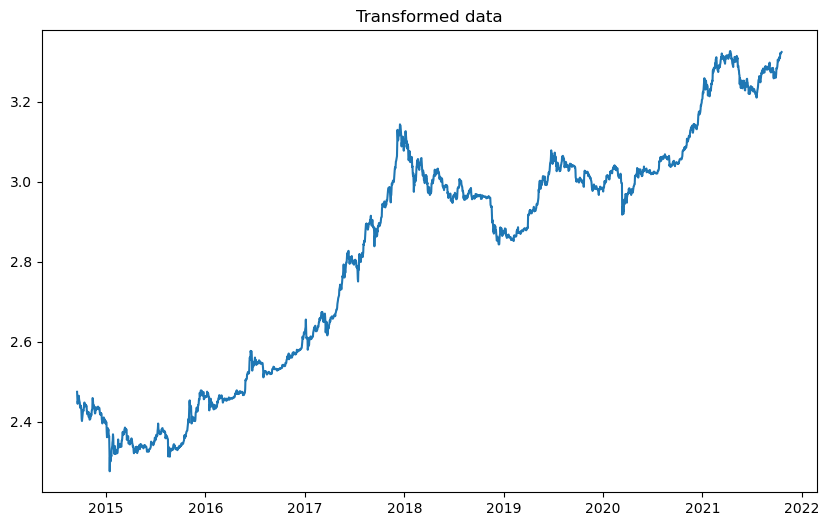

In [10]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data');

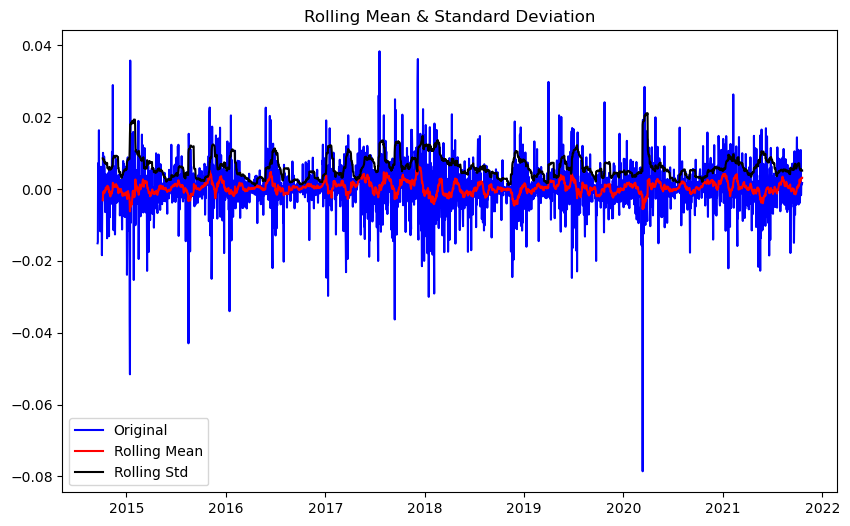

Results of Dickey-Fuller Test:
Test Statistic                -1.548004e+01
p-value                        2.563303e-28
#Lags Used                     9.000000e+00
Number of Observations Used    2.575000e+03
Critical Value (1%)           -3.432892e+00
Critical Value (5%)           -2.862663e+00
Critical Value (10%)          -2.567368e+00
dtype: float64


In [11]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

# Prophet

In [12]:
# Preprocessing:Creating a two-column dataset to use in time series analysis
df = Bitcoin_data
prophet_data = df[['Close']]
#prophet_data = prophet_data.set_index('Date')
scaled_data = df_close_shift
#To convert the frequency of the dataframe to weekly and then return the values of the axis.(periods of 7 days)
weekly_prophet = scaled_data.resample('W').mean()
#Reset the index of the DataFrame, and remove missing values with dropna() 
week_seasonality = weekly_prophet.reset_index().dropna()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


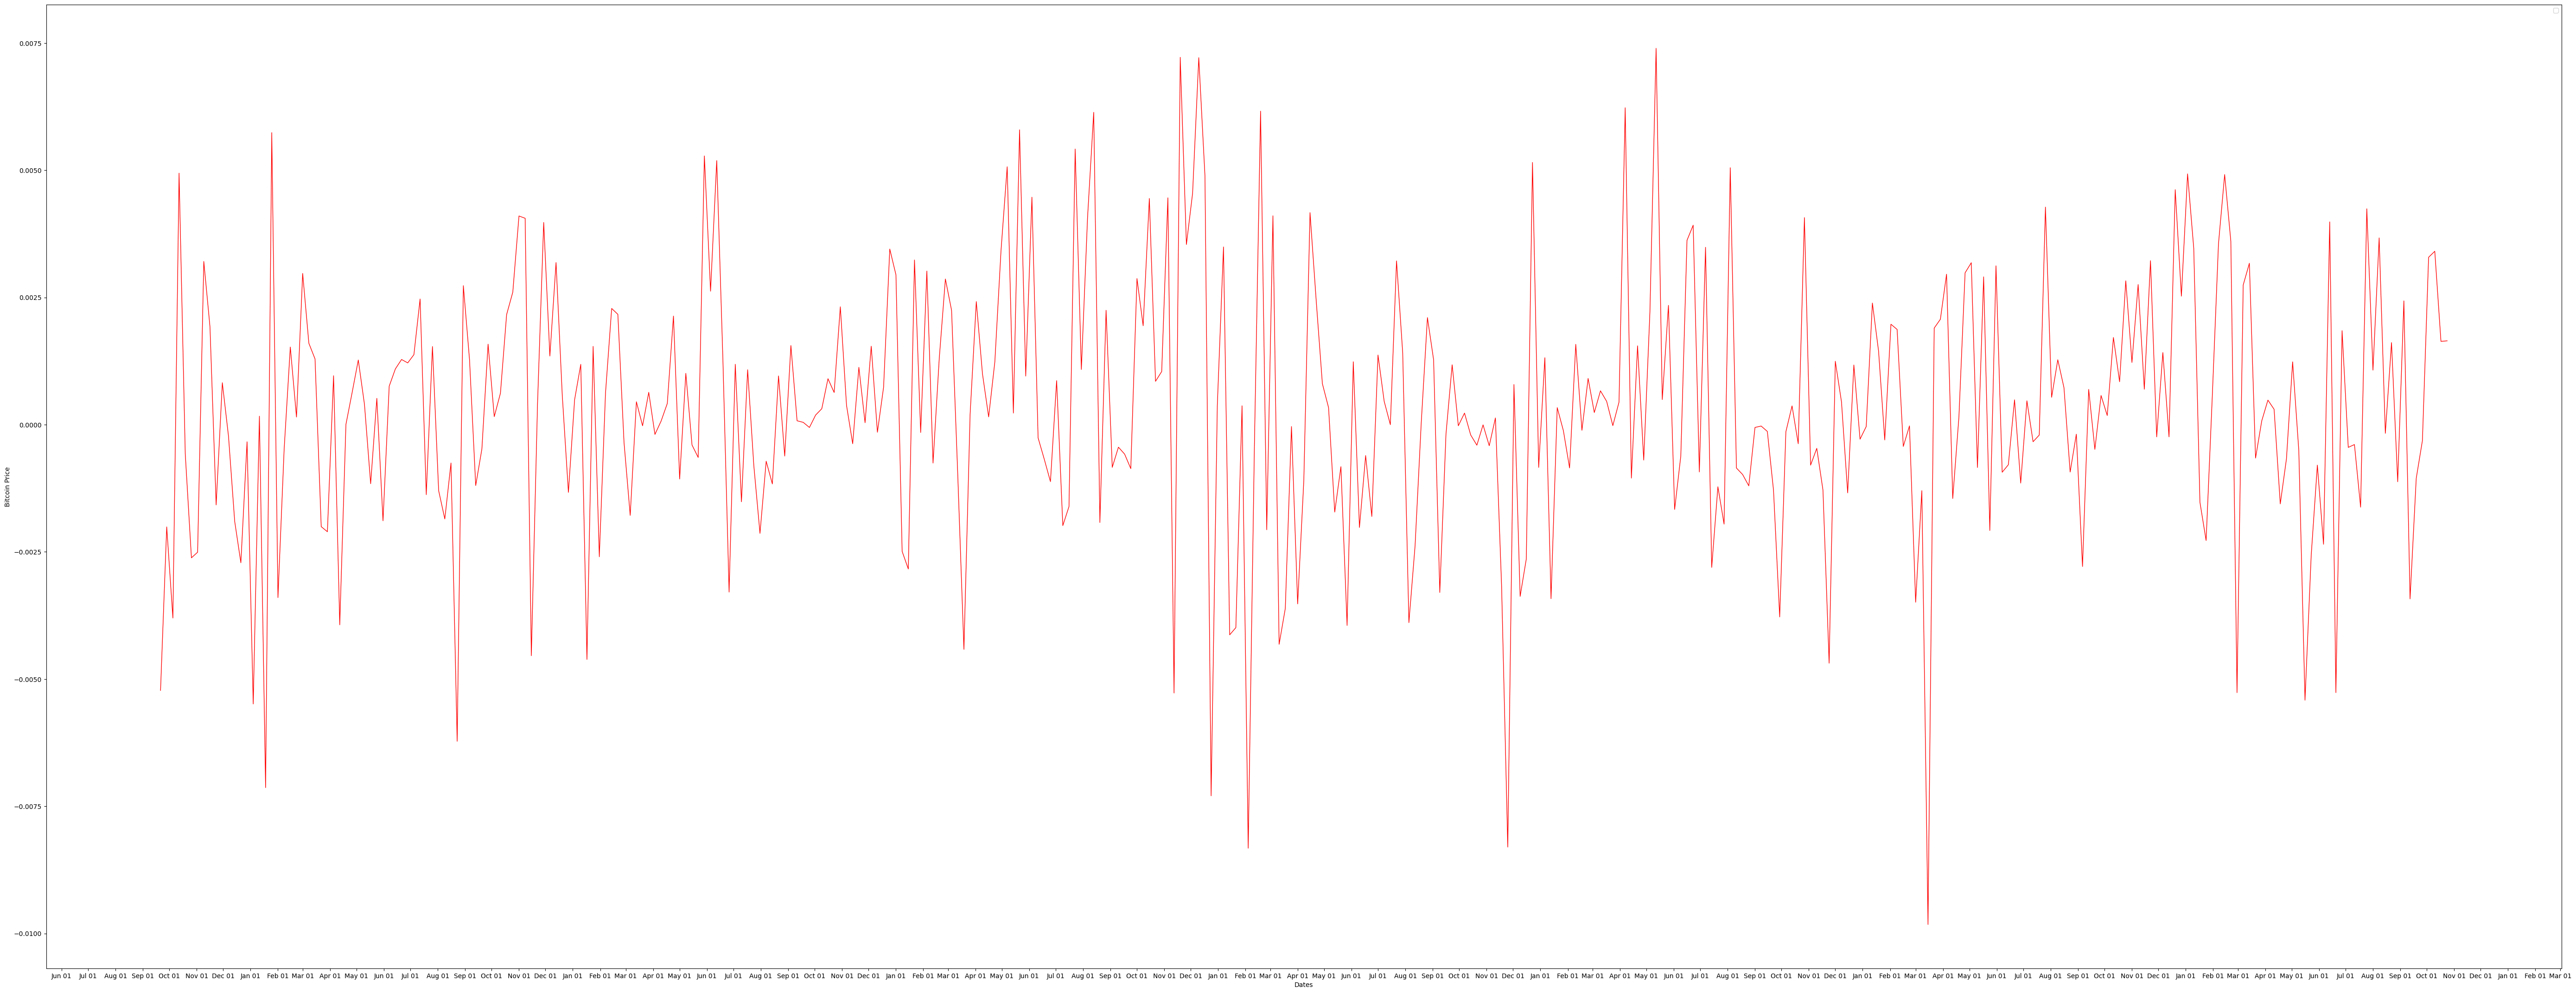

In [13]:
# Plotting the weekly average prices by month
fig = plt.figure(figsize = (70, 27))
ax = plt.axes()
#set ticks every month to  show the month value on the x axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.plot(week_seasonality['Date'],week_seasonality['Close'],color='r', linewidth=1)
plt.xlabel("Dates")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.show()

In [14]:
#Preprocessing :The input for the prophet is the two columns of ds which is the formated version of the "Date" and "y" as the target
week_seasonality.columns = ['ds', 'y']
#Modeling and analysis based on yearly seasonlity
prophet_model=Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, changepoint_range=1) 
#interval_width sets the uncertainty interval to produce a confidence interval around the forecast
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)
#fitting the model
prophet_model.fit(week_seasonality)
#To predict the average Close prices of next month
future_month = prophet_model.make_future_dataframe(freq='W', periods=4)  

18:17:33 - cmdstanpy - INFO - Chain [1] start processing
18:17:33 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
#predict the future month
forecast_future_month = prophet_model.predict(future_month)


In [16]:
daily_mean = scaled_data.resample('D').mean()
#Reset the index of the DataFrame, and remove missing values with dropna() 
daily_prophet = daily_mean.reset_index().dropna()
daily_prophet.sort_values(by=['Date'])
daily_prophet.columns = ['ds', 'y']
prophet_model=Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,changepoint_range=1) 
#interval_width sets the uncertainty interval to produce a confidence interval around the forecast
prophet_model.add_seasonality(name='daily_seasonailty', period=1, fourier_order=5, prior_scale=0.02)
prophet_model.fit(daily_prophet)
#periods will generate a range of evenly spaced dates from start to end inclusively number of elements in the resulting DatetimeIndex
future_days = prophet_model.make_future_dataframe(freq='D', periods=70) 

18:17:35 - cmdstanpy - INFO - Chain [1] start processing
18:17:35 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
next_day = prophet_model.predict(future_days[-505:])
pred_array = next_day['yhat'].values
prophet_test_days = len(next_day)
print(prophet_test_days)
prophet_test_original = df_close.iloc[-prophet_test_days:]
pred_size = len(next_day)
pred_array = pred_array.reshape(pred_size, 1)
pred_data = pd.DataFrame(pred_array[:,0], prophet_test_original.index,columns=['Close'])
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-prophet_test_days:] 
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)
pred_data_prophet = pred_data

505


In [18]:
true_data = Bitcoin_data['Close'].values
true_data = true_data[-prophet_test_days:].reshape(prophet_test_days, 1)
test_mae = mean_absolute_error(true_data, pred_data)
test_mse = mean_squared_error(true_data, pred_data, squared=True)
test_rmse = mean_squared_error(true_data, pred_data, squared=False)
test_r2 = r2_score(true_data, pred_data)

print("\n****---- Test Metrics ----****")
print(" MAE : {:.4f}".format(np.average(test_mae.item())))
print("RMSE : {:.4f}".format(np.average(test_rmse.item())))



****---- Test Metrics ----****
 MAE : 952.7997
RMSE : 1498.4658
